<a href="https://colab.research.google.com/github/vishal-khot/Flower-Classification/blob/main/FlowerClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import cv2
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
image_shape = (224,224)

In [ ]:
#Load image labels
tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

16384/10484 [==============================================] - 0s 0us/step


['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [ ]:
classifier = Sequential()
classifier.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=image_shape+(3,)))

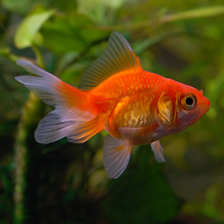

In [ ]:
gold_fish = Image.open("goldfish.jpg").resize(image_shape)
gold_fish

In [ ]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [ ]:
gold_fish[np.newaxis, ...]
gold_fish[np.newaxis, ...].shape

(1, 224, 224, 3)

In [ ]:
result = classifier.predict(gold_fish[np.newaxis, ...])
label = np.argmax(result)
print(label)

2


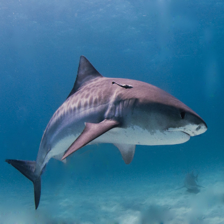

In [ ]:
tiger_shark = Image.open("tigershark.jpg").resize(image_shape)
tiger_shark

In [ ]:
tiger_shark = np.array(tiger_shark)/255.0
print(image_labels[np.argmax(classifier.predict(tiger_shark[np.newaxis, ...]))])

spotlight


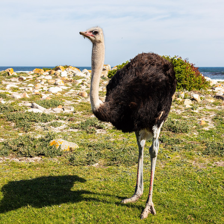

In [ ]:
ostrich = Image.open("ostrich.jpg").resize(image_shape)
ostrich

In [ ]:
ostrich = np.array(ostrich)/255.0
print(image_labels[np.argmax(classifier.predict(ostrich[np.newaxis, ...]))])

ostrich


In [ ]:
#Load flowers dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [ ]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/15274443248_76b9f3eb24.jpg'),
 PosixPath('datasets/flower_photos/roses/17449165090_dfb27af360_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5717319579_190e85c7d1_m.jpg'),
 PosixPath('datasets/flower_photos/roses/14982802401_a3dfb22afb.jpg'),
 PosixPath('datasets/flower_photos/roses/18220342690_f1c20134bd.jpg')]

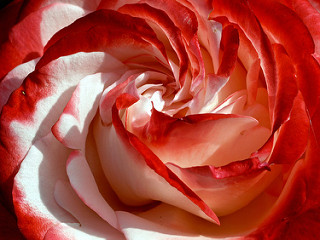

In [ ]:
Image.open(str(roses[1]))

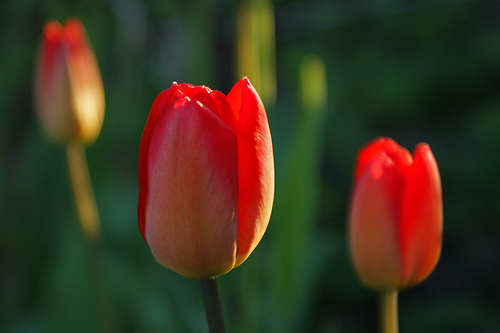

In [ ]:
tulips = list(data_dir.glob('tulips/*'))
Image.open(str(tulips[0]))

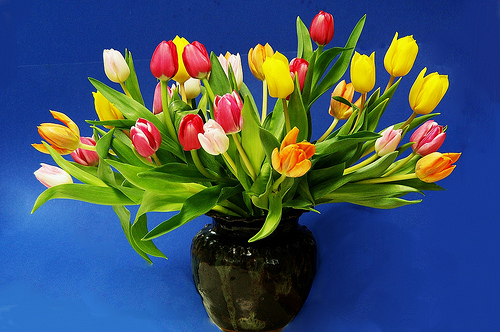

In [ ]:
Image.open(str(tulips[5]))

In [ ]:
#Read flowers images from disk into numpy array using opencv
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [ ]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [ ]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/15274443248_76b9f3eb24.jpg'),
 PosixPath('datasets/flower_photos/roses/17449165090_dfb27af360_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5717319579_190e85c7d1_m.jpg'),
 PosixPath('datasets/flower_photos/roses/14982802401_a3dfb22afb.jpg'),
 PosixPath('datasets/flower_photos/roses/18220342690_f1c20134bd.jpg')]

In [ ]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/15274443248_76b9f3eb24.jpg'

In [ ]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [ ]:
img.shape

(301, 500, 3)

In [ ]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [ ]:
X, y = [], []

In [ ]:
for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [ ]:
X = np.array(X)
y = np.array(y)
X.shape

(3670, 224, 224, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
#Preprocessing: scale images
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

In [ ]:
len(X_test)/len(X)

0.2501362397820163

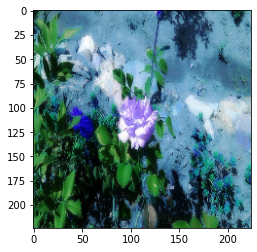

In [ ]:
plt.imshow(X[0])

In [ ]:
y[0]

0

In [ ]:
x0_resized = cv2.resize(X[0], image_shape)
x1_resized = cv2.resize(X[1], image_shape)
x2_resized = cv2.resize(X[2], image_shape)
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
for p in predicted:
    print(image_labels[p])

shower curtain
pillow
envelope


In [ ]:
#Now take pre-trained model and retrain it using flowers images
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [ ]:
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [ ]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 99s 1s/step - loss: 1.2147 - acc: 0.5275
Epoch 2/5
86/86 [==============================] - 85s 983ms/step - loss: 0.4654 - acc: 0.8361
Epoch 3/5
86/86 [==============================] - 85s 991ms/step - loss: 0.3561 - acc: 0.8833
Epoch 4/5
86/86 [==============================] - 84s 981ms/step - loss: 0.2837 - acc: 0.9124
Epoch 5/5
86/86 [==============================] - 84s 980ms/step - loss: 0.2418 - acc: 0.9288


In [ ]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 29s 973ms/step - loss: 0.3830 - acc: 0.8617


[0.3830370306968689, 0.8616557717323303]

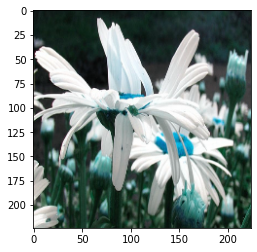

In [ ]:
plt.imshow(X_test_scaled[0])

In [ ]:
y_test[0]

1

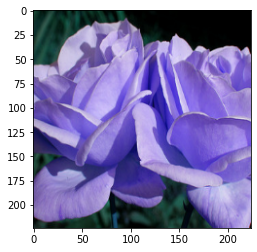

In [ ]:
plt.imshow(X_test_scaled[1])

In [ ]:
y_test[1]

0

In [ ]:
x_test_scaled_0_resized = cv2.resize(X_test_scaled[0], image_shape)
x_test_scaled_1_resized = cv2.resize(X_test_scaled[1], image_shape)
predicted_test=model.predict(np.array([x0_resized, x_test_scaled_1_resized]))
predicted_test_labels = np.argmax(predicted_test, axis=1)
predicted_test_labels

array([2, 0])